In [13]:
%matplotlib inline
import os
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt

In [14]:
path = '../data/test_data/signal_window_8/test_data_unbalanced_lookahead_0.pkl'
with open(path, 'rb') as f:
    test_data = pickle.load(f)
signals = test_data['signals']
labels = test_data['labels']
sample_indices = test_data['sample_indices']
window_start = test_data['window_start']

In [15]:
num_elms = len(window_start)
i_elms = np.random.choice(num_elms, 1, replace=False)

i_start = window_start[i_elms]
if i_elms < num_elms - 1:
    i_stop = (window_start[i_elms + 1] - 1)
else:
    i_stop = labels.size
print(i_start.dtype, i_stop.dtype)
i_start[0], i_stop[0]

int64 int64


(158151, 164315)

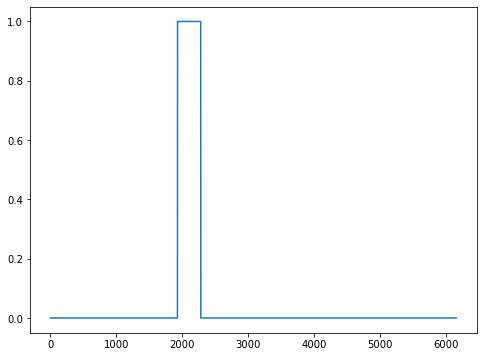

In [16]:
elm_labels = labels[i_start[0]:i_stop[0]]
elm_time = np.arange(elm_labels.size)
fig = plt.figure(figsize=(8,6))
plt.plot(elm_time, elm_labels)
plt.show()

In [21]:
active_elm = np.where(elm_labels > 0.)[0]
print(active_elm[:5])
active_elm_start = active_elm[0]
active_elm_end = active_elm[-1]
active_elm_start_mod = (
    (active_elm_start - 500) if (active_elm_start - 500) > 0 else 0
)
active_elm_end_mod = (
    (active_elm_end + 500) if (active_elm_end + 500) < len(elm_labels) - 1 else len(elm_labels) - 1
)

[1929 1930 1931 1932 1933]


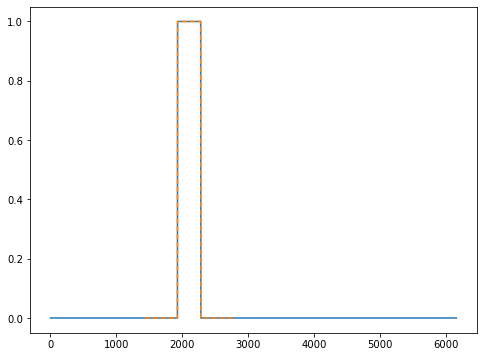

In [28]:
fig = plt.figure(figsize=(8,6))
elm_labels_mod = elm_labels[active_elm_start_mod:active_elm_end_mod]
elm_time_mod = np.arange(active_elm_start_mod, active_elm_end_mod)
plt.plot(elm_time, elm_labels)
plt.plot(elm_time_mod, elm_labels_mod, '--')
plt.show()

In [ ]:
signals = test_data[0]
labels = test_data[1]
sample_indices = test_data[2]
window_start = test_data[3]
num_elms = len(window_start)
elm_predictions = dict()
for i, i_elm in enumerate(num_elms):
    i_start = window_start[i_elm]
    if i_elm < num_elms - 1:
        i_stop = window_start[i_elm + 1] - 1
    else:
        i_stop = labels.size
    # gathering the indices for active elm events
    elm_signals = signals[i_start[0] : i_stop[0]]
    elm_labels = labels[i_start[0] : i_stop[0]]
    active_elm = np.where(elm_labels > 0.0)[0]
    elm_start = active_elm[0]
    elm_end = active_elm[-1]
    # add a buffer of a given number of time frames
    # in both start and end
    elm_start_extended = (elm_start - 500) if (elm_start - 500) > 0 else 0
    elm_end_extended = (
        (elm_end + 500)
        if (elm_end + 500) < len(elm_labels) - 1
        else len(elm_labels) - 1
    )
    elm_signals_extended = elm_signals[elm_start_extended:elm_end_extended]
    elm_labels_extended = elm_labels[elm_start_extended:elm_end_extended]
    predictions = np.zeros(
        elm_labels_extended.size
        - args.signal_window_size
        - args.label_look_ahead
        + 1
    )
    for j in range(predictions.size):
        if j % 500 == 0:
            print(f"  Time {j}")
        input_signals = torch.as_tensor(
            elm_signals_extended[
                j : j + args.signal_window_size, :, :
            ].reshape([1, 1, args.signal_window_size, 8, 8]),
            dtype=torch.float32,
        )
        input_signals = input_signals.to(device)
        predictions[j] = model(input_signals)
    elm_predictions[window_start[i_elm]] = {
        "labels": elm_labels_extended,
        "predictions": predictions,
        "elm_time": np.arange(elm_start_extended, elm_end_extended),
    }